# VQA Simulation
- Author: Sungguk Cha
- Date: Jun 8, 2021

In [1]:
import sys
import time

sys.path.append("..")

from proto.vqa_pb2 import VQAInput
from proto.vqa_pb2_grpc import VQAStub

import cv2
from google_trans_new import google_translator
import grpc
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
from PIL import Image

CHUNK_SIZE = 1024 * 1024  # 1MB

In [2]:
translator = google_translator()

def list2string(qs):
    trans = list()
    ans = translator.translate(qs[0], lang_tgt='en')
    trans.append(ans)
    for i in range(1, len(qs)):
        t = translator.translate(qs[i], lang_tgt='en')
        ans += ", " + t
        trans.append(t)
    return trans, ans

class Client(object):
    def __init__(self, ip="localhost", port=5959):
        self.server_ip = ip
        self.server_port = port
        self.stub = VQAStub(
            grpc.insecure_channel(
                self.server_ip + ":" + str(self.server_port)
            )
        )

    def get_service(self, image_path, questions):
        with open(image_path, 'rb') as rf:
            image_byte = rf.read()
        trans, text = list2string(questions)
        text_byte = bytes(text, 'utf-8')

        binary_iterator = self._generate_binary_iterator(image_byte, text_byte)

        check1 = time.time()

        output_iterator = self.stub.Determinate(binary_iterator)
        
        check2 = time.time()
        print(f"{check2 - check1:.2f} second passed for receiving iterator")

        text_data = bytearray()
        for input_data in output_iterator:
            if input_data.text is not None and len(input_data.text) != 0:
                text_data.extend(input_data.text)
        text = bytes(text_data)
        text = text.decode('utf-8')
        
        check3 = time.time()        
        print(f"{check3 - check2:.2f} second passed for streaming")
        
        answers = text.split(',')
        for i, q in enumerate(questions):
            print(f"{q}( {trans[i]}) : {answers[i]}")
        

    @staticmethod
    def _generate_binary_iterator(image_binary, text_binary):
        for idx in range(0, len(image_binary), CHUNK_SIZE):
            yield VQAInput(image=image_binary[idx:idx+CHUNK_SIZE])
        for idx in range(0, len(text_binary), CHUNK_SIZE):
            yield VQAInput(text=text_binary[idx:idx+CHUNK_SIZE])

In [3]:
args = OmegaConf.load("../conf/config.yaml")
client = Client(port=args.port)

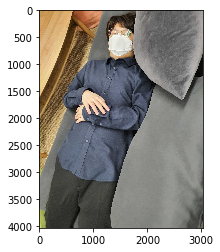

In [4]:
image_dir = "../sample/sleeping_star.jpg"
image = Image.open(image_dir)
image_cv2 = cv2.imread(image_dir)
plt.imshow(image)
plt.show()

In [5]:
questions = ["Is there a person?", "How old the person looks like?", "Is the person holding something?", "What the person is doing?"]
client.get_service(image_dir, questions)

0.03 second passed for receiving iterator
12.23 second passed for streaming
Is there a person?( Is there a person? ) : yes
How old the person looks like?( How old the person looks like? ) :  50
Is the person holding something?( Is the person holding something? ) :  yes
What the person is doing?( What the person is doing? ) :  sitting


In [6]:
questions = ["사진에 사람이 있습니까?", "사람은 몇 살 처럼 보여?", "사람이 뭐 들고 있어?", "사람은 뭘 하고 있어?"]
client.get_service(image_dir, questions)

0.00 second passed for receiving iterator
11.42 second passed for streaming
사진에 사람이 있습니까?( Do you have anyone in the picture? ) : yes
사람은 몇 살 처럼 보여?( How old do you look like a person? ) :  30
사람이 뭐 들고 있어?( What are you holding? ) :  gloves
사람은 뭘 하고 있어?( What are people doing? ) :  sitting


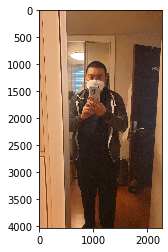

In [7]:
image_dir = "../sample/bbak.jpg"
image = Image.open(image_dir)
image_cv2 = cv2.imread(image_dir)
plt.imshow(image)
plt.show()

In [10]:
questions = ["Is there a person?", "How old the person looks like?", "Is the person holding something?", "What item the person is holding?", "What the person is doing?"]
client.get_service(image_dir, questions)

0.00 second passed for receiving iterator
11.67 second passed for streaming
Is there a person?( Is there a person? ) : yes
How old the person looks like?( How old the person looks like? ) :  30
Is the person holding something?( Is the person holding something? ) :  yes
What item the person is holding?( What item the person is holding? ) :  cell phone
What the person is doing?( What the person is doing? ) :  standing


In [11]:
questions = ["사진에 사람이 있습니까?", "사람은 몇 살 처럼 보여?", "사람이 무언가를 들고 있어?", "사람이 무엇을 들고 있어?", "사람은 뭘 하고 있어?"]
client.get_service(image_dir, questions)

0.00 second passed for receiving iterator
11.82 second passed for streaming
사진에 사람이 있습니까?( Do you have anyone in the picture? ) : no
사람은 몇 살 처럼 보여?( How old do you look like a person? ) :  30
사람이 무언가를 들고 있어?( Are you holding something? ) :  yes
사람이 무엇을 들고 있어?( What is a person holding it? ) :  cell phone
사람은 뭘 하고 있어?( What are people doing? ) :  standing


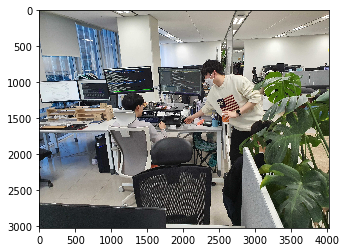

In [15]:
image_dir = "../sample/beforebbakbbak.jpg"
image = Image.open(image_dir)
image_cv2 = cv2.imread(image_dir)
plt.imshow(image)
plt.show()

In [16]:
questions = ["Is there a person?", "How old the person looks like?", "Is the person holding something?", "What item the person is holding?", "What the person is doing?"]
client.get_service(image_dir, questions)

0.00 second passed for receiving iterator
12.16 second passed for streaming
Is there a person?( Is there a person? ) : yes
How old the person looks like?( How old the person looks like? ) :  30
Is the person holding something?( Is the person holding something? ) :  yes
What item the person is holding?( What item the person is holding? ) :  mouse
What the person is doing?( What the person is doing? ) :  office


In [17]:
questions = ["사진에 사람이 있습니까?", "사람은 몇 살 처럼 보여?", "사람이 무언가를 들고 있어?", "사람이 무엇을 들고 있어?", "사람은 뭘 하고 있어?"]
client.get_service(image_dir, questions)

0.00 second passed for receiving iterator
12.39 second passed for streaming
사진에 사람이 있습니까?( Do you have anyone in the picture? ) : yes
사람은 몇 살 처럼 보여?( How old do you look like a person? ) :  30
사람이 무언가를 들고 있어?( Are you holding something? ) :  yes
사람이 무엇을 들고 있어?( What is a person holding it? ) :  mouse
사람은 뭘 하고 있어?( What are people doing? ) :  working


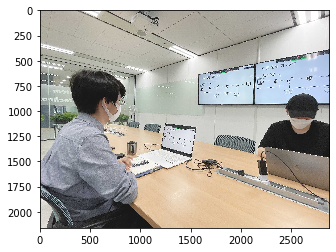

In [18]:
image_dir = "../sample/bean.jpg"
image = Image.open(image_dir)
image_cv2 = cv2.imread(image_dir)
plt.imshow(image)
plt.show()

In [19]:
questions = ["Is there a person?", "How old the person looks like?", "Is the person holding something?", "What item the person is holding?", "What the person is doing?"]
client.get_service(image_dir, questions)

0.00 second passed for receiving iterator
11.55 second passed for streaming
Is there a person?( Is there a person? ) : yes
How old the person looks like?( How old the person looks like? ) :  30
Is the person holding something?( Is the person holding something? ) :  yes
What item the person is holding?( What item the person is holding? ) :  laptop
What the person is doing?( What the person is doing? ) :  using laptop


In [20]:
questions = ["사진에 사람이 있습니까?", "사람은 몇 살 처럼 보여?", "사람이 무언가를 들고 있어?", "사람이 무엇을 들고 있어?", "사람은 뭘 하고 있어?"]
client.get_service(image_dir, questions)

0.00 second passed for receiving iterator
11.33 second passed for streaming
사진에 사람이 있습니까?( Do you have anyone in the picture? ) : yes
사람은 몇 살 처럼 보여?( How old do you look like a person? ) :  30
사람이 무언가를 들고 있어?( Are you holding something? ) :  no
사람이 무엇을 들고 있어?( What is a person holding it? ) :  laptop
사람은 뭘 하고 있어?( What are people doing? ) :  working


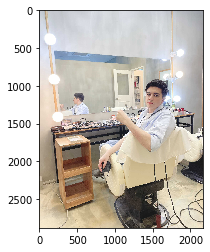

In [21]:
image_dir = "../sample/matt.jpg"
image = Image.open(image_dir)
image_cv2 = cv2.imread(image_dir)
plt.imshow(image)
plt.show()

In [22]:
questions = ["Is there a person?", "How old the person looks like?", "Is the person holding something?", "What item the person is holding?", "What the person is doing?"]
client.get_service(image_dir, questions)

0.00 second passed for receiving iterator
10.97 second passed for streaming
Is there a person?( Is there a person? ) : yes
How old the person looks like?( How old the person looks like? ) :  young
Is the person holding something?( Is the person holding something? ) :  yes
What item the person is holding?( What item the person is holding? ) :  gun
What the person is doing?( What the person is doing? ) :  sitting


In [23]:
questions = ["사진에 사람이 있습니까?", "사람은 몇 살 처럼 보여?", "사람이 무언가를 들고 있어?", "사람이 무엇을 들고 있어?", "사람은 뭘 하고 있어?"]
client.get_service(image_dir, questions)

0.00 second passed for receiving iterator
10.94 second passed for streaming
사진에 사람이 있습니까?( Do you have anyone in the picture? ) : yes
사람은 몇 살 처럼 보여?( How old do you look like a person? ) :  30
사람이 무언가를 들고 있어?( Are you holding something? ) :  yes
사람이 무엇을 들고 있어?( What is a person holding it? ) :  gun
사람은 뭘 하고 있어?( What are people doing? ) :  sitting
